In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import re
from collections import Counter
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import json
import yaml
import time
import torch
pd.set_option('display.max_colwidth', None)
import plotly.express as px
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

### Ouverture et nettoyage des données

In [2]:
# Function to recursively convert dictionary values to strings
def dict_values_to_strings(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dict_values_to_strings(value)
        else:
            dictionary[key] = str(value)
    return dictionary

# Function to decode tokens using the YAML dictionary
def decode_with_yaml(text, yaml_dict):
    text = str(text)  # Convert text to string
    for token, meaning in yaml_dict.items():
        if isinstance(meaning, dict):
            yaml_dict[token] = dict_values_to_strings(meaning)
        text = text.replace(str(token), str(yaml_dict[token]))  # Convert both token and meaning to string
    return text


# Load the YAML file "tokens"
yaml_file_path = r'tokens.yml'  # Update with your YAML file path
with open(yaml_file_path, 'r', encoding='utf-8') as yaml_file:
    tokens = yaml.safe_load(yaml_file)

# Specify the file path of the JSON data
json_file_path = r'entities.json'

# Open the JSON file "entities" using 'with open' and UTF-8 encoding
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    # Load the JSON data
    data = json.load(json_file)

#Replacing the "idems" that are not the first ones in a page by the content of the preceding cell
pattern = r'.(?=idem)'
for num_page, text_page in data.items():
    list_pers = text_page.split("\n")

    for i, pers in enumerate(list_pers):
        match = re.search(pattern, pers)

        if match:
            # Extraction of the token
            token = match.group(0)
            # Former element of the list
            preceding_element = list_pers[i - 1]
            # Apply the regular expression
            info_associated_match = re.search(re.escape(token) + r'\s*(\S+)', preceding_element)
            if info_associated_match:
                # Extraction of the information
                info_associated = info_associated_match.group(1)
                list_pers[i] = list_pers[i].replace("idem", "info_associated")

def replace_tokens(donnees_dict, tokens_dict):
    for key, value in donnees_dict.items():
        for champ, token in tokens_dict.items():
            value = value.replace(token['start'], f"{champ} ")
            value = value.replace(token['end'], '')
        data[key] = value
    return data

In [3]:
data_without_token = replace_tokens(data, tokens)
data_without_token = list(data_without_token.values())
list_data_withouts_token = [el for el in data_without_token]
list_data = [text.split("\n") for text in list_data_withouts_token]
list_data = [el for liste in list_data_withouts_token for el in liste.split("\n")]

In [4]:
col_to_create = list(tokens.keys())

# Function to extract "champs"
def extract(texte):
    data_dict = {}
    for champ in col_to_create:
        value = re.search(rf'\b{champ}\b (\S+)', texte)
        if value:
            data_dict[champ] = value.group(1)
        else:
            data_dict[champ] = None
    return data_dict

# List of dictionnaries based on the data
data_list = [extract(text) for text in list_data]
df = pd.DataFrame(data_list)

In [5]:
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)
df

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
0,25,None,Garçon,None,Cyrille,None,None,française,None,menuisier,Breton,None
1,30,None,Garçon,None,Auguste,None,None,Piémontaise,None,vitrier,None,Ferazzi
2,24,None,Garçon,None,Pierre,None,None,Piémontaise,None,vitrier,None,Machol
3,48,None,Homme,None,Alexandre,None,None,française,None,prop,None,Desbois
4,30,None,None,None,Zélie,sa,None,française,None,prop,Vignat,None
...,...,...,...,...,...,...,...,...,...,...,...,...
25440,None,1869,None,None,Marie,chef,Pailharès,idem,None,None,None,Chameton-Dideron
25441,None,1863,None,Cara,Marie,chef,St,idem,None,ouv,None,Ode
25442,None,1886,None,Baretto,Nello,chef,Castel,italienne,None,manoeuvre,None,Berni
25443,None,1887,None,None,Annunziata,épouse,idem,idem,None,None,Berni-Laureti,None


In [6]:
# Missing values
missing_values = df.isnull().sum() / len(df) * 100
missing_values = missing_values.reset_index()
missing_values.columns = ['Column', 'MissingValues']
missing_values = missing_values.sort_values(by='MissingValues', ascending=False)

# Plot
fig = px.bar(missing_values, x='Column', y='MissingValues', text='MissingValues',
             title="Pourcentage de valeurs manquantes par catégorie",
             width=700,
             height=500)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside', textfont_size=15)
fig.update_layout(yaxis=dict(title='Pourcentage de valeurs manquantes'),
                  xaxis=dict(title='Catégorie'),
                  font = dict(size=12))
fig.show()

In [7]:
#We homogeneize all the absence of answers
df.replace(["Neant", "néant", "neant", ""], None, inplace=True)
df.dropna(axis=1, how='all', inplace=True)

In [8]:
#We drop the rows for which the column
df.dropna(subset=['link'], inplace=True)

In [9]:
#Creation of the chef dataset
df_chef = df[df["link"].isin(["CHEF", "chef", "Chef", "chf", "cheg", "ch."])]
df_chef

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
37,None,1877,None,P.O,Elie,chef,Cercottes,française,None,tourneur,None,Furet
42,None,1879,None,None,Gaston,chef,Landes,française,None,cocher,None,Poitout
46,None,1872,None,Charpentier,Louis,chef,Ruan,française,None,journalier,None,Debard
52,None,1860,None,None,Germaine,chef,None,française,None,domestique,None,Hatton
53,None,1869,None,None,Marie,chef,Vottouville,française,None,ménagère,None,Violette
...,...,...,...,...,...,...,...,...,...,...,...,...
25435,None,1855,None,None,Augusta,chef,Bésayes,idem,None,None,None,Turpin-Faucon
25437,None,1856,None,None,Raymond,chef,idem,idem,None,None,None,Lambert
25440,None,1869,None,None,Marie,chef,Pailharès,idem,None,None,None,Chameton-Dideron
25441,None,1863,None,Cara,Marie,chef,St,idem,None,ouv,None,Ode


### Statistiques descriptives sur l'ensemble du dataset


In [10]:
df.describe()

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
count,13031,7130,6744,2802,20662,20729,8681,12679,398,12014,16403,4108
unique,126,150,6,846,1272,294,2055,59,126,898,6713,3012
top,2,1901,Fille,patron,Marie,chef,idem,française,veuve,idem,idem,Le
freq,333,138,1934,639,2923,4414,3150,7521,61,3133,672,33


In [11]:
# Unique values
unique_values_count = df.nunique()
unique_values_count = unique_values_count.reset_index()
unique_values_count.columns = ['Column', 'UniqueValues']

# Sort the DataFrame by the UniqueValuesCount column
unique_values_count_sorted = unique_values_count.sort_values(by='UniqueValues', ascending=False)

# Plot with the sorted data
fig = px.bar(unique_values_count_sorted, x='Column', y='UniqueValues', text='UniqueValues',
             title="Nombre de valeurs uniques par catégorie",
             width=700, height=500)
fig.update_traces(texttemplate='%{text}', textposition='outside', textfont_size=13)
fig.update_layout(yaxis=dict(title='Nombre de valeurs uniques'),
                  xaxis=dict(title='Catégorie'),
                  font = dict(size=12))
fig.show()

### Statistiques descriptives sur le dataset des chefs de famille

Statistiques et graphiques généraux




In [12]:
df_chef.describe()

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
count,2572,2027,799,1407,4602,4619,2305,3470,111,4340,797,3801
unique,83,104,6,429,537,6,1001,40,45,648,683,2816
top,50,1864,Homme,patron,Jean,chef,idem,française,veuve,cultivateur,Le,Le
freq,74,50,631,572,502,4414,487,2131,35,541,19,28


In [13]:
# Histogram of birth years
df_birth_year = df_chef.copy()
df_birth_year = df_birth_year[df_birth_year['birth_date'].apply(lambda x: len(str(x)) == 4)]
df_birth_year = df_birth_year[df_birth_year['birth_date']!='idem']
df_birth_year = df_birth_year.dropna(subset=['birth_date'])

df_birth_year['birth_date'] = df_birth_year['birth_date'].astype(int)
px.histogram(df_birth_year, x='birth_date',
             title='Histogramme des années de naissance au sein des chefs de famille',
             nbins=50,
             width=900,
             height=500)

In [14]:
# Calculation of the median and mean age of the chef dataset
df_age = df_chef.copy()
df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) != 4)]
df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) != 3)]
df_age = df_age[~df_age['age'].str.contains('\⁇')]
df_age = df_age[~df_age['age'].str.contains('\?')]
df_age = df_age.replace(to_replace='mois', value=1, regex=True)
df_age = df_age.replace(to_replace='mpis', value=1, regex=True)
df_age = df_age.replace(to_replace='semaines', value=1, regex=True)
df_age = df_age.replace(to_replace='jours', value=0, regex=True)
df_age = df_age.replace(to_replace='jour', value=0, regex=True)
df_age['age'] = df_age['age'].str.replace(' ans', '')
df_age['age'] = df_age['age'].str.replace('ans', '')
df_age['age'] = df_age['age'].str.replace('an', '')
df_age['age'] = df_age['age'].str.replace("1'", '1')
df_age = df_age[df_age['age'].apply(lambda x: len(str(x)) < 3)]
df_age['age'] = df_age['age'].astype(int)

In [15]:
print(f"Age moyen des chefs de famille: {df_age['age'].mean()}")
print(f"Age médian des chefs de famille: {df_age['age'].median()}")

Age moyen des chefs de famille: 49.59766081871345
Age médian des chefs de famille: 49.0


In [16]:
df_chef.groupby("firstname").size().reset_index(name='count').sort_values(by='count', ascending=False).head(15)

,firstname,count
299,Jean,502
440,Pierre,293
374,Marie,221
341,Louis,219
225,François,174
312,Joseph,144
64,Antoine,119
262,Henri,87
85,Auguste,86
118,Charles,76


In [17]:
# Most observed names in the chef dataset
top_names = df_chef['firstname'].value_counts().head(10)
top_names_df = top_names.reset_index()
top_names_df.columns = ['Prénom', 'Nombre de fois donné']

colors = px.colors.qualitative.Plotly[:len(top_names_df)]

fig = px.bar(top_names_df, x='Prénom', y='Nombre de fois donné',
             title='Les 10 prénoms les plus courants parmi les chefs de famille',
             labels={'Prénom': 'Prénom', 'Nombre de fois donné': 'Nombre de fois donné'},
             width=700,
             height=500,
             color='Prénom',
             color_discrete_sequence=colors)

fig.update_layout(xaxis_tickangle=-45,
                  xaxis=dict(title='Prénom'),
                  yaxis=dict(title='Nombre de fois donné'),
                  title=dict(x=0.5),
                  font=dict(size=14))
fig.show()

In [18]:
df_chef.groupby("occupation").size().reset_index(name='count').sort_values(by='count', ascending=False).head(20)

,occupation,count
293,cultivateur,541
286,cult,232
411,journalier,220
392,idem,184
541,prop,93
551,propriétaire,85
356,fermier,81
588,sans,75
336,employé,60
412,journalière,60


In [19]:
#Most observed occupations for the chef dataset
top_occupation = df_chef['occupation'].value_counts().head(10)
top_occupation_df = top_names.reset_index()
top_occupation_df.columns = ['Occupation', "Nombre d'occurences"]

colors = px.colors.qualitative.Plotly[:len(top_occupation_df)]

fig = px.bar(top_occupation_df, x='Occupation', y="Nombre d'occurences",
             title='Les 10 occupations les plus courantes parmi les chefs de famille',
             labels={'Occupation': 'Occupation', "Nombre d'occurences": "Nombre d'occurences"},
             width=700,
             height=500,
             color='Occupation',
             color_discrete_sequence=colors)

fig.update_layout(xaxis_tickangle=-45,
                  xaxis=dict(title='Occupation'),
                  yaxis=dict(title="Nombre d'occurences"),
                  title=dict(x=0.5),
                  font=dict(size=14))
fig.show()

In [20]:
df_chef.groupby("civil_status").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,civil_status,count
3,Homme,631
4,Veuf,64
5,Veuve,64
2,Garçon,19
1,Fille,18
0,Femme,3


In [21]:
# Civil Status for the chef dataset
top_civil_status = df_chef['civil_status'].value_counts().head(10)
top_civil_status_df = top_civil_status.reset_index()
top_civil_status_df.columns = ['Statut Civil', "Nombre d'occurences"]

colors = px.colors.qualitative.Plotly[:len(top_civil_status_df)]

fig = px.bar(top_civil_status_df, x='Statut Civil', y="Nombre d'occurences",
             title='Occurence des statuts civils parmi les chefs de famille',
             labels={'Statut Civil': 'Statut Civil', "Nombre d'occurences": "Nombre d'occurences"},
             width=700,
             height=500,
             color='Statut Civil',
             color_discrete_sequence=colors)

fig.update_layout(xaxis_tickangle=-45,
                  xaxis=dict(title='Statut Civil'),
                  yaxis=dict(title="Nombre d'occurences"),
                  title=dict(x=0.5),
                  font=dict(size=14))
fig.show()


Wordclouds

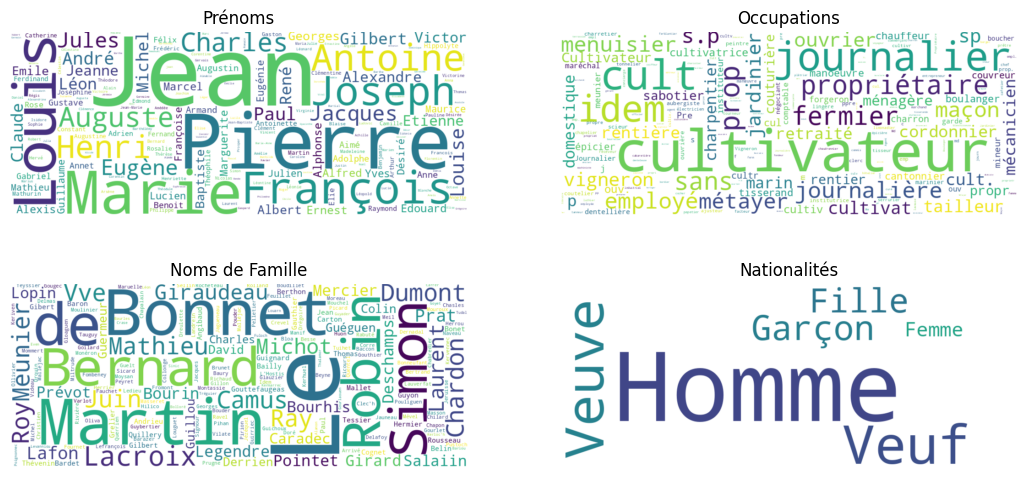

In [22]:
# Wordclouds for the chef dataset concerning First Names, Occupations, Last Names and Nationalities
fig, ax = plt.subplots(2, 2, figsize=(13, 6))
wordcloud1 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df_chef.firstname.dropna().astype(str).tolist()))
ax[0][0].imshow(wordcloud1, interpolation='bilinear')
ax[0][0].axis('off')
ax[0][0].set_title('Prénoms')
wordcloud2 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df_chef.occupation.dropna().astype(str).tolist()))
ax[0][1].imshow(wordcloud2, interpolation='bilinear')
ax[0][1].axis('off')
ax[0][1].set_title('Occupations')
wordcloud3 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df_chef.surname.dropna().astype(str).tolist()))
ax[1][0].imshow(wordcloud3, interpolation='bilinear')
ax[1][0].axis('off')
ax[1][0].set_title('Noms de Famille')
wordcloud4 = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(Counter(df_chef.civil_status.dropna().astype(str).tolist()))
ax[1][1].imshow(wordcloud4, interpolation='bilinear')
ax[1][1].axis('off')
ax[1][1].set_title('Nationalités')
plt.show()

## Modèle choisi : CamembertForSequenceClassification

In [23]:
df

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
4,30,None,None,None,Zélie,sa,None,française,None,prop,Vignat,None
10,30,None,Femme,None,Mathilde,sa,None,française,None,profess,de,None
11,11,None,Garçon,None,Georges,le,None,française,None,None,de,None
12,8,None,Garçon,None,Henro,le,None,française,None,None,de,None
13,5,None,Garçon,None,Gaston,le,None,française,None,None,de,None
...,...,...,...,...,...,...,...,...,...,...,...,...
25440,None,1869,None,None,Marie,chef,Pailharès,idem,None,None,None,Chameton-Dideron
25441,None,1863,None,Cara,Marie,chef,St,idem,None,ouv,None,Ode
25442,None,1886,None,Baretto,Nello,chef,Castel,italienne,None,manoeuvre,None,Berni
25443,None,1887,None,None,Annunziata,épouse,idem,idem,None,None,Berni-Laureti,None


In [24]:
# Transforming the link column in a binary chef variable
df['link'] = df['link'].apply(lambda x: 1 if x == 'chef' else 0)

In [25]:
# Dropping the column link to build the train set
df_train=df.drop('link', axis=1)

In [26]:
# Loading the Tokenization
from transformers import CamembertTokenizerFast
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

# Concatenatation of the text data of the other columns to train the model
concatenated_texts = [f"{age} {civil_status} {employer} {nationality} {occupation} {firstname} {birth_date} {lob} {surname_household}" for age, civil_status, employer, nationality, occupation, firstname, birth_date, lob, surname_household in zip(df_train['age'], df_train['civil_status'], df_train['employer'], df_train['nationality'], df_train['occupation'], df_train['firstname'], df_train['birth_date'], df_train['lob'], df_train['surname_household'])]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [27]:
X = concatenated_texts
y = df['link'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, val_texts, y_train, val_labels = train_test_split(X_train, y_train, test_size=.2)

In [28]:
#Tokenization
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

#Encoding
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Convert the integer labels to one-hot encoded format
encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
test_labels_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))
val_labels_encoded = encoder.transform(np.array(val_labels).reshape(-1, 1))

train_dataset = Dataset(train_encodings, train_labels_encoded)
val_dataset = Dataset(val_encodings, val_labels_encoded)
test_dataset = Dataset(test_encodings, test_labels_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [29]:
#Using GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

#CamembertForSequenceClassification
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#AdamW Optimization
optim = AdamW(model.parameters(), lr=5e-5)

start_time = time.time()

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

end_time = time.time()

# Calculate and print the running time
print("Total running time:", end_time - start_time, "seconds")

model.eval()

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Total running time: 245.09484100341797 seconds


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

Accuracy: 0.9502562556526982
F1 Score: 0.9508493502466016
Confusion Matrix:
[[2480  108]
 [  57  672]]


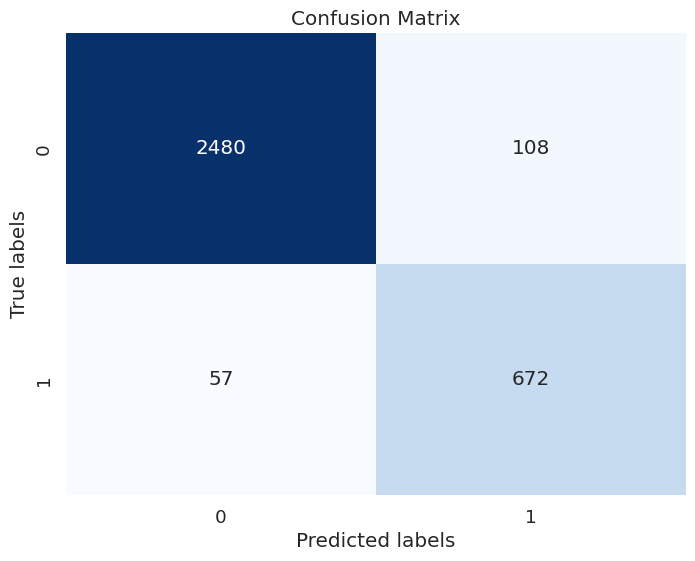

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Model in evaluation mode
model.eval()

# DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over batches in the validation dataset
for batch in val_loader:
    with torch.no_grad():
        # Move batch to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        # Get predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)
        true_labels = torch.argmax(labels, dim=1).cpu().numpy()
        all_true_labels.extend(true_labels)

# Compute accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Compute F1 score
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("F1 Score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [31]:
#False positives
df_results_test = pd.DataFrame({'text': val_texts, 'true_label': val_labels, 'predicted_label': all_predictions})
df_results_test.loc[(df_results_test["true_label"]==0)&(df_results_test["predicted_label"]==1)].head(10)

,text,true_label,predicted_label
17,55 None None None cultivateur Alain None None Le,0,1
22,6 Garçon None None None Julie None None Ghadeyras,0,1
81,45 None rue française charretier Edouard None None Lepaut,0,1
85,40 None None None T. Auguste None None Cesson,0,1
137,59 None idem française idem Louis None None Verdier,0,1
138,None None None française None Louise 1876 St Rangée,0,1
147,51 None patron française m Théophile None None None,0,1
223,39 Homme None None scieur Antoine None None None,0,1
232,34 None None None Couturière Marie None None Tablo,0,1
266,25 None None None brasseur Yves None None None,0,1


In [32]:
#False negatives
df_results_test = pd.DataFrame({'text': val_texts, 'true_label': val_labels, 'predicted_label': all_predictions})
df_results_test.loc[(df_results_test["true_label"]==1)&(df_results_test["predicted_label"]==0)].head(10)

,text,true_label,predicted_label
16,70 None None None cultivateur Aimée None None None,1,0
126,74 None None française sp Louis None None None,1,0
263,72 Homme None None culv Annet None None None,1,0
325,61 None None idem journalière Françoise None None None,1,0
335,37 None None None domestique Antoine None None None,1,0
453,None None patron français md Julien 1886 idem None,1,0
525,None None Delorme française marbrier Jean 1871 Lancoins None,1,0
650,96 Homme None None maçon André None Puy None,1,0
676,None None None française None Charles 1869 Valenciennes None,1,0
682,30 None None idem cultivateur Claude None None None,1,0


### Variation sur les paramètres

#### Nombre d'époques

In [33]:
#Using GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

#CamembertForSequenceClassification
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#AdamW Optimization
optim = AdamW(model.parameters(), lr=5e-5)

start_time = time.time()

for epoch in range(5):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

end_time = time.time()

# Calculate and print the running time
print("Total running time:", end_time - start_time, "seconds")

model.eval()

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Total running time: 408.70553970336914 seconds


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

Accuracy: 0.9442267108833283
F1 Score: 0.9444029435886667
Confusion Matrix:
[[2489   99]
 [  86  643]]


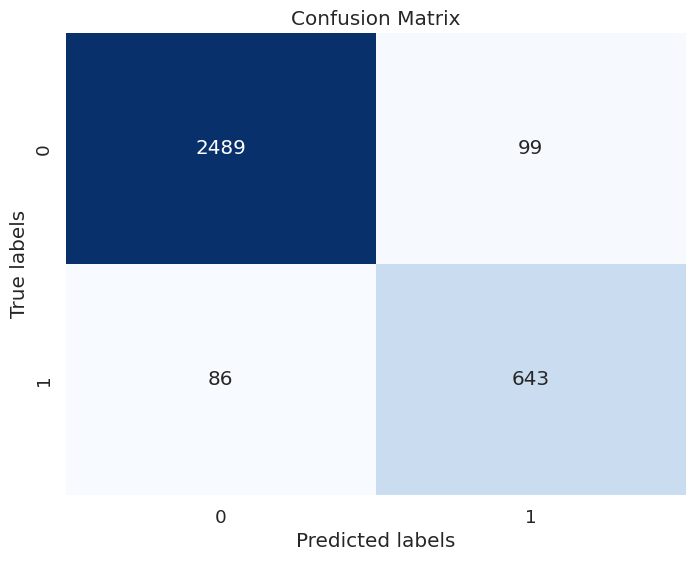

In [34]:
# Model in evaluation mode
model.eval()

# DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over batches in the validation dataset
for batch in val_loader:
    with torch.no_grad():
        # Move batch to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        # Get predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)
        true_labels = torch.argmax(labels, dim=1).cpu().numpy()
        all_true_labels.extend(true_labels)

# Compute accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Compute F1 score
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("F1 Score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Learning rate

In [35]:
#Using GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

#CamembertForSequenceClassification
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#AdamW Optimization
optim = AdamW(model.parameters(), lr=1e-3)

start_time = time.time()

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

end_time = time.time()

# Calculate and print the running time
print("Total running time:", end_time - start_time, "seconds")

model.eval()

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Total running time: 244.35057473182678 seconds


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

Accuracy: 0.7802230931564667
F1 Score: 0.6839008857202153
Confusion Matrix:
[[2588    0]
 [ 729    0]]


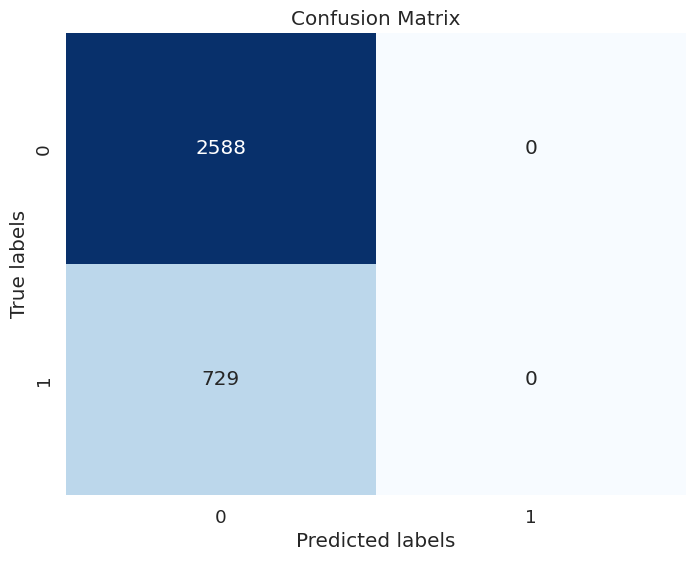

In [36]:
# Model in evaluation mode
model.eval()

# DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over batches in the validation dataset
for batch in val_loader:
    with torch.no_grad():
        # Move batch to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        # Get predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)
        true_labels = torch.argmax(labels, dim=1).cpu().numpy()
        all_true_labels.extend(true_labels)

# Compute accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Compute F1 score
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("F1 Score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Batch size

In [37]:
#Using GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

#CamembertForSequenceClassification
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

#AdamW Optimization
optim = AdamW(model.parameters(), lr=5e-5)

start_time = time.time()

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

end_time = time.time()

# Calculate and print the running time
print("Total running time:", end_time - start_time, "seconds")

model.eval()

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Total running time: 228.0644347667694 seconds


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

Accuracy: 0.7802230931564667
F1 Score: 0.6839008857202153
Confusion Matrix:
[[2588    0]
 [ 729    0]]


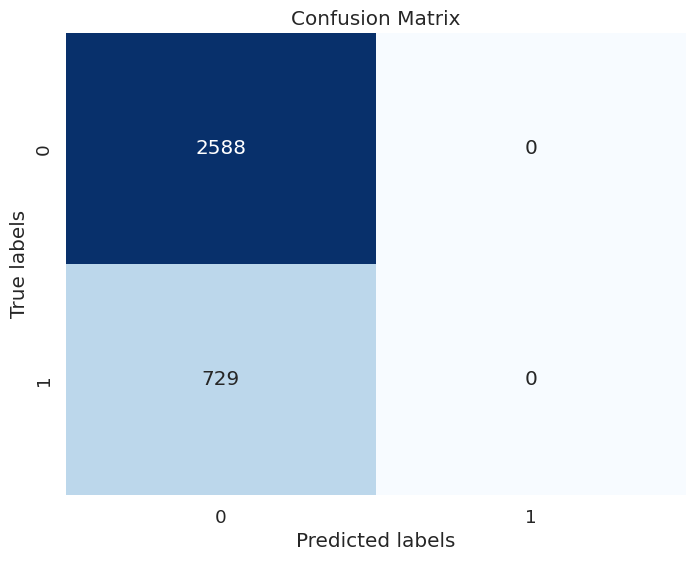

In [38]:
# Model in evaluation mode
model.eval()

# DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over batches in the validation dataset
for batch in val_loader:
    with torch.no_grad():
        # Move batch to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        # Get predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)
        true_labels = torch.argmax(labels, dim=1).cpu().numpy()
        all_true_labels.extend(true_labels)

# Compute accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Compute F1 score
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("F1 Score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Comparaison avec d'autres modèles

### MultinomialNB

#### Bag of Words

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, val_texts, y_train, val_labels = train_test_split(X_train, y_train, test_size=.2)

In [40]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
val_texts_counts = vectorizer.transform(val_texts)
X_test_counts = vectorizer.transform(X_test)

In [41]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

predicted_labels = clf.predict(X_test_counts)

f1 = f1_score(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion matrix:", conf_matrix)

F1-score: 0.6723796967699407
Accuracy: 0.8801254220935841
Confusion matrix: [[3139   91]
 [ 406  510]]


#### TD-IDF

In [42]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_dev_tf = tf_transformer.transform(val_texts_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

In [43]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tf, y_train)

predicted_labels = clf.predict(X_test_tf)

f1 = f1_score(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion matrix:", conf_matrix)

F1-score: 0.7310924369747899
Accuracy: 0.8919440424505547
Confusion matrix: [[3089  141]
 [ 307  609]]


### RandomClassifier

#### TD-IDF

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, val_texts, y_train, val_labels = train_test_split(X_train, y_train, test_size=.2)

In [45]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

predicted_labels = clf.predict(X_test)

f1 = f1_score(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion matrix:", conf_matrix)

F1-score: 0.6214532871972318
Accuracy: 0.8680656054027979
Confusion matrix: [[3150   80]
 [ 467  449]]


#### Fast-Text

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, val_texts, y_train, val_labels = train_test_split(X_train, y_train, test_size=.2)

In [47]:
from gensim.models import FastText
fasttext_model = FastText(sentences=X_train, vector_size=100, window=5, min_count=5, workers=4, sg=1)

train_embeddings = np.array([fasttext_model.wv[words.split()].mean(axis=0) for words in X_train])
test_embeddings = np.array([fasttext_model.wv[words.split()].mean(axis=0) for words in X_test])

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, y_train)

predicted_labels = rf_model.predict(test_embeddings)

f1 = f1_score(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion matrix:", conf_matrix)

F1-score: 0.7255483106105513
Accuracy: 0.8883260974433188
Confusion matrix: [[3071  159]
 [ 304  612]]
